In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Question_Pairs_BiLSTM

Mounted at /content/drive
/content/drive/MyDrive/Question_Pairs_BiLSTM


### Data Preprocessing

In [ ]:
import torch
import torchtext
device = "cuda:0" if torch.cuda.is_available() else "cpu"
!nvidia-smi

Thu Mar 25 14:29:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
question = torchtext.legacy.data.Field(
    sequential = True,
    lower = True,
    batch_first = True,
    tokenize = 'spacy',
    pad_first = True,
    use_vocab = True
    )
target = torchtext.legacy.data.Field(
    sequential = False,
    use_vocab = False,
    is_target = True
    )

In [ ]:
train_data, validation_data = torchtext.legacy.data.TabularDataset.splits(
    path = 'data', 
    train = 'train_dataset.csv',
    validation = 'val_dataset.csv',
    format = 'csv',
    skip_header = True,
    fields = [('q1', question), ('q2', question), ('t', target)]
    )

In [ ]:
question.build_vocab(train_data)
vocab = question.vocab

In [ ]:
train_loader, validation_loader = torchtext.legacy.data.BucketIterator.splits(
    (train_data, validation_data), 
    sort_key = lambda x: len(x.q1)+len(x.q2),
    batch_sizes = (64,128),
    device = device
    )

In [ ]:
for q, t in train_loader:
    print('questions_1: {}, shape: {}'.format(q[0], q[0].shape))
    print('')
    print('questions_2: {}, shape: {}'.format(q[1], q[1].shape))
    print('')
    print('lables: {}, shape: {}'.format(t, t.shape))
    break

questions_1: tensor([[   1,    1,    1,  ..., 1035,  278,    2],
        [   1,    1,    1,  ..., 5092,  493,    2],
        [   1,    1,    1,  ...,  483,  339,    2],
        ...,
        [   1,    1,    1,  ...,  101,  190,    2],
        [   1,    1,    1,  ...,  164,  409,    2],
        [   1,    1,    1,  ..., 1072,  187,    2]], device='cuda:0'), shape: torch.Size([64, 65])

questions_2: tensor([[    1,     1,     1,  ..., 73361,   311,     2],
        [    1,     1,     1,  ...,     8,  5092,     2],
        [    1,     1,     1,  ...,   483,   136,     2],
        ...,
        [    1,     1,     1,  ...,    95,   885,     2],
        [    1,     1,     1,  ...,  3892,  1572,     2],
        [    1,     1,     1,  ...,  1072,   262,     2]], device='cuda:0'), shape: torch.Size([64, 31])

lables: tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 1

In [ ]:
for q, t in validation_loader:
    print('questions_1: {}, shape: {}'.format(q[0], q[0].shape))
    print('')
    print('questions_2: {}, shape: {}'.format(q[1], q[1].shape))
    print('')
    print('lables: {}, shape: {}'.format(t, t.shape))
    break

questions_1: tensor([[    1,    46,  2909, 30099,     2],
        [    1,     4,     5, 26040,     2],
        [    1,     4,     5, 13577,     2],
        [    1,     4,     5, 10014,     2],
        [    1,    11,    62,   352,     2],
        [    1,     4,     5, 28157,     2],
        [    1,     4,     5, 64666,     2],
        [    1,     4,     5,     0,     2],
        [    1,    69,  1503,  1937,     2],
        [    1,    24, 30286,    92,     2],
        [    1,    46,     5,  4670,     2],
        [    1,     4,    13, 18297,     2],
        [    1,     5,    42,  8640,     2],
        [    1,     5, 62803, 15207,     2],
        [    1,     5, 35139,   283,     2],
        [    1,    15,   884,  2045,     2],
        [    1,     4,     5, 14394,     2],
        [    1,     4,     5, 86007,     2],
        [    1,     4,     5, 46712,     2],
        [    1,     5, 10688,   219,     2],
        [    1,     5,  2997,  3054,     2],
        [    1,     4,     5, 27899,     2

### Bidirectional LSTM

In [ ]:
import torch.nn as nn
import numpy as np

In [ ]:
class BiLSTM(nn.Module):
  def __init__(self, n_vocabs, embed_dims, n_lstm_units, n_lstm_layers, n_output_classes):
    super(BiLSTM, self).__init__()
    self.v = n_vocabs
    self.e = embed_dims
    self.u = n_lstm_units
    self.l = n_lstm_layers
    self.o = n_output_classes
    self.padd_idx = vocab.stoi['<pad>']
    self.embed = nn.Embedding(
        self.v,
        self.e,
        self.padd_idx
        )
    self.bilstm = nn.LSTM(
        self.e,
        self.u,
        self.l,
        batch_first = True,
        bidirectional = True,
        dropout = 0.5
        )
    self.linear = nn.Linear(
        self.u * 4,
        self.o
        )  
  
  def forward(self, X1, X2):
    # initial_hidden
    h0 = torch.zeros(self.l * 2, X1.size(0), self.u).to(device)
    c0 = torch.zeros(self.l * 2, X1.size(0), self.u).to(device)
    
    # embedding
    out1 = self.embed(X1.to(device))
    out2 = self.embed(X2.to(device))

    # pack_padded_sequence
    # out1 = nn.utils.rnn.pack_padded_sequence(out1, ??, batch_first=True, enforce_sorted=False)
    # out2 = nn.utils.rnn.pack_padded_sequence(out2, ??, batch_first=True, enforce_sorted=False)
    
    # NxTxh, lxNxh
    out1, _ = self.bilstm(out1, (h0, c0))
    out2, _ = self.bilstm(out2, (h0, c0))
    
    # pad_packed_sequence
    # out1, _ = nn.utils.rnn.pad_packed_sequence(out1, batch_first=True)
    # out2, _ = nn.utils.rnn.pad_packed_sequence(out2, batch_first=True)

    # take only the final time step
    out1 = out1[:, -1, :]
    out2 = out2[:, -1, :]
    
    # concatenate out1&2
    out = torch.cat((out1, out2), 1)
    
    # linear layer
    out = self.linear(out)

    iout = torch.max(out, 1)[1]
    return iout, out

In [ ]:
train_labels = torch.cat([t for q1, t in train_loader])
negative = (train_labels == 0.).sum(dim=0).item()
positive = (train_labels == 1.).sum(dim=0).item()

In [ ]:
print(f'number data in training set {len(train_data)}')
print(f'number of negative data in training set {negative}')
print(f'number of positive data in training set {positive}')

number data in training set 323429
number of negative data in training set 203998
number of positive data in training set 119431


class_weight :

n = 203998 * (119431 / (119431 + 203998)) = 75329.3153613312

p = 119431 * (203998 / (119431 + 203998)) = 75329.3153613312

In [ ]:
torch.manual_seed(42)
model = BiLSTM(len(vocab), 512, 512, 2, 2).to(device)
class_weight = torch.tensor([positive/(positive+negative), negative/(positive+negative)]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weight, reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [ ]:
print(model)

BiLSTM(
  (embed): Embedding(87399, 512, padding_idx=1)
  (bilstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=2048, out_features=2, bias=True)
)


In [ ]:
import sys
from tqdm import tqdm
from datetime import datetime

num_epochs = 5
losses = []
accuracies  = []
val_losses = []
val_accuracies = []
val_loss_min = np.inf

for epoch in range(num_epochs):
    print('------------------------------------------------------------------------------------------')
    print('epoch: {}/{}:'.format(epoch + 1, num_epochs))   
    print('------------------------------------------------------------------------------------------')
    t0 = datetime.now()

    train_tqdm_bar = tqdm(enumerate(train_loader), total = (len(train_loader)), leave = False, position = 0, file = sys.stdout, dynamic_ncols = True)
    val_tqdm_bar = tqdm(enumerate(validation_loader), total = (len(validation_loader)),  leave = False, position = 0, file = sys.stdout, dynamic_ncols = True)

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    model.train()
    for idx, (docs, labels) in train_tqdm_bar:
        iout, out = model(docs[0], docs[1])
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1)
        optimizer.step()
        running_loss += loss
        running_corrects += torch.sum(iout == labels)
        train_tqdm_bar.set_description(desc = 'train'.format(epoch + 1, num_epochs))
        batch_idx = (idx + 1) * 64

        train_tqdm_bar.set_postfix(
            loss = running_loss.item() / batch_idx if idx + 1 < len(train_loader) else running_loss.item() / len(train_loader.dataset)
            ,acc = running_corrects.item() / batch_idx if idx + 1 < len(train_loader) else running_corrects.item() / len(train_loader.dataset)
            )
    
    model.eval()
    with torch.no_grad():
        for val_idx, (v_docs, v_labels) in val_tqdm_bar:
            v_iout, v_out = model(v_docs[0], v_docs[1])
            v_loss = criterion(v_out, v_labels)
            val_running_loss += v_loss
            val_running_corrects += torch.sum(v_iout == v_labels)
            val_tqdm_bar.set_description('validate'.format(epoch + 1, num_epochs))
            val_batch_idx = (val_idx + 1) * 128

            val_tqdm_bar.set_postfix(
                val_loss = val_running_loss.item() / val_batch_idx if val_idx + 1 < len(validation_loader) else val_running_loss.item() / len(validation_loader.dataset)
                ,val_acc = val_running_corrects.item() / val_batch_idx if val_idx + 1 < len(validation_loader) else val_running_corrects.item() / len(validation_loader.dataset)
                )
    
    epoch_loss = running_loss/len(train_loader.dataset)
    losses.append(epoch_loss)
    epoch_accuracy = running_corrects/len(train_loader.dataset)
    accuracies.append(epoch_accuracy)
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_losses.append(val_epoch_loss)
    val_epoch_accuracy = val_running_corrects/len(validation_loader.dataset)
    val_accuracies.append(val_epoch_accuracy)

    checkpoint = {
            'epoch': epoch + 1
            ,'state_dict': model.state_dict()
            ,'optimizer' : optimizer.state_dict()
            ,'val_loss_min' : val_epoch_loss
            }
    
    print('training loss: {:.4f}, acc: {:.2f}'.format(epoch_loss, epoch_accuracy))
    print('validation loss: {:.4f}, acc: {:.2f}'.format(val_epoch_loss, val_epoch_accuracy))
    print('elapsed time: {}'.format(str(datetime.now() - t0).split('.')[0]))

    if val_epoch_loss <= val_loss_min:
      print('validation loss decreased from {:.4f} to {:.4f}, saving model...'.format(val_loss_min, val_epoch_loss))
      torch.save(checkpoint, 'checkpoint/ex1/question_pairs_lowest_val_loss_epoch_{}.pth'.format(epoch + 1))
      val_loss_min = val_epoch_loss

------------------------------------------------------------------------------------------
epoch: 1/5:
------------------------------------------------------------------------------------------
training loss: 0.0084, acc: 0.73
validation loss: 0.0039, acc: 0.77
elapsed time: 0:11:15
validation loss decreased from inf to 0.0039, saving model...
------------------------------------------------------------------------------------------
epoch: 2/5:
------------------------------------------------------------------------------------------
training loss: 0.0070, acc: 0.79
validation loss: 0.0037, acc: 0.77
elapsed time: 0:11:20
validation loss decreased from 0.0039 to 0.0037, saving model...
------------------------------------------------------------------------------------------
epoch: 3/5:
------------------------------------------------------------------------------------------
training loss: 0.0058, acc: 0.83
validation loss: 0.0039, acc: 0.77
elapsed time: 0:11:21
---------------------

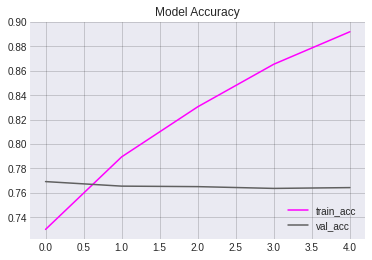

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(accuracies, color = 'magenta')
plt.plot(val_accuracies, color = '#606060')
plt.title('Model Accuracy')
plt.legend(['train_acc', 'val_acc'], loc = 'lower right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)

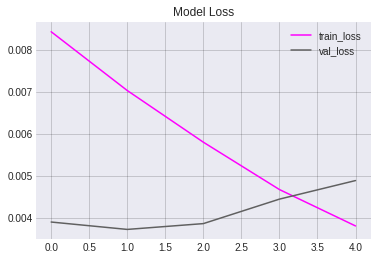

In [ ]:
plt.figure()
plt.plot(losses, color = 'magenta')
plt.plot(val_losses, color = '#606060')
plt.title('Model Loss')
plt.legend(['train_loss', 'val_loss'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)